<a href="https://colab.research.google.com/github/Amal-Nasir/SCNN_Colab/blob/main/LIDC_Lob_testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd ..

/


In [ ]:
cd content/drive/MyDrive/MedIx\ REU/Datasets

/content/drive/MyDrive/MedIx REU/Datasets


In [ ]:
from __future__ import absolute_import
from __future__ import print_function
import tensorflow as tf
import numpy as np  # linear alg
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import random
import keras
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Input, Flatten, Dense, Dropout, Lambda
from keras import backend as K
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, silhouette_score, silhouette_samples, homogeneity_completeness_v_measure
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize, MinMaxScaler
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN, SpectralClustering, AgglomerativeClustering
#from s_dbw import S_Dbw, SD

In [ ]:
##### Parameters #####
random.seed(25)
run = 100
metric_names = ['Silhouette Coefficients ', 'Average Silhouette Metric ', 'Scaled Multiplied Silhouette Metric ']
name9 = 'test case {}/{} Correlation.xlsx'.format(run, metric_names[0])
writer1 = pd.ExcelWriter(name9)
name10 = 'test case {}/{} Correlation.xlsx'.format(run, metric_names[1])
writer2 = pd.ExcelWriter(name10)
name11 = 'test case {}/{} Correlation.xlsx'.format(run, metric_names[2])
writer3 = pd.ExcelWriter(name11)
#writer_list = [writer1, writer2, writer3]                            # uncomment this out if we want to look at all of the metrics
writer_list = [writer1]                                               # comment this out if we want to look at all of the metrics
metric_names = ['Scaled Multiplied Silhouette Metric ']               # comment this out if we want to look at all of the metrics

In [ ]:
##### User defined functions #####
def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))

In [ ]:
def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

In [ ]:
def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
      uses y_true as Y and y_pred as the Euclidean distance between dissimilar points
    '''
    margin = 1
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    sqaure_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * sqaure_pred + (1 - y_true) * margin_square)

In [ ]:
def compute_accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true)

In [ ]:
def accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))

In [ ]:
def cluster_centroid(embeddings, y_sc, numclusters):
    centroids = [] #center indice values
    for i in range(numclusters): #for each class...
        inds = np.where(y_sc==i)[0] #list of all images within the same proposed class
        inds_embed = embeddings[inds] #feature vectors of all these images
        inds_embed1 = np.array(inds_embed) #numpy array of this matrix
        column_mean = inds_embed1.mean(axis=0) #mean per dimension (x, y, z, etc.)
        centroids.append(column_mean) #append to the list
    return centroids

In [ ]:
def wss(centroids, embeddings, y_sc, numclusters, n): #in 2d - total wss (not average)
    wss_percluster = [] # list of total distance per class
    closest_inds = []
    farthest_inds = []
    for i in range(numclusters):
        inds = np.where(y_sc==i)[0] #list of all images within the same proposed class
        inds_embed = embeddings[inds] #feature vectors of all these images
        inds_embed1 = np.array(inds_embed) #numpy array of this matrix
        after_subtraction = inds_embed1 - centroids[i] #subtracting the centroid indices from the image indices
        squared_matrix = np.square(after_subtraction) #square the distance values
        sum_rows = np.sum(squared_matrix, axis = 1) #add all fo the distances of the same image
        sum_cols = np.sum(sum_rows) #add all of image distances together of the same class
        wss_percluster.append(sum_cols) #include this in the total distances per class
        ## find the images farthest/closest to centroid
        indclosest = np.argpartition(sum_rows, n)[:n]
        indfarthest = np.argpartition(sum_rows, -n)[-n:]
        indclosestnum = inds[indclosest]
        indfarthestnum = inds[indfarthest]
        closest_inds.append(indclosestnum)
        farthest_inds.append(indfarthestnum) #final image number
    tot_wss = np.sum(wss_percluster) #sum all of the distances from all of the clusters into 1 value
    return tot_wss, closest_inds, farthest_inds

In [ ]:
# Silhouette plot
def silhouette_plt(y_sc, silhouette_vals, run, numclusters, indicator):
    cluster_labels = np.unique(y_sc)
    ax_lower, ax_upper = 0, 0
    cticks = []
    sil_plot = plt.figure()
    for i, k in enumerate(cluster_labels):
        c_silhouette_vals = silhouette_vals[y_sc == k]
        c_silhouette_vals.sort()
        ax_upper += len(c_silhouette_vals)
        color = plt.jet()
        plt.barh(range(ax_lower, ax_upper), c_silhouette_vals, height=1.0,
                         edgecolor='none', color=color)
        cticks.append((ax_lower + ax_upper) / 2)
        ax_lower += len(c_silhouette_vals)
    silhouette_avg = np.mean(silhouette_vals)
    plt.axvline(silhouette_avg, color="red", linestyle="--")
    plt.yticks(cticks, cluster_labels)
    plt.ylabel('Cluster')
    plt.xlabel('Silhouette coefficient')
    if indicator == 0:
        str2 = 'Unscaled Silhouette Plot For {} Clusters'.format(numclusters)
        name = 'test case {}/{} cluster/og silhouette plot'.format(run, numclusters)
    else:
        str2 = 'Min-Max Silhouette Plot For {} Clusters'.format(numclusters)
        name = 'test case {}/{} cluster/minmax silhouette plot'.format(run, numclusters)
    plt.title(str2)
    plt.tight_layout()
    # plt.show()
    # sil_plot.savefig(name)
    return silhouette_avg

In [ ]:
# Find the average silhouette number per cluster
def silhouette_cluster_average(y_sc, silhouette_values, numclusters):
    silhouette_clusters = []
    for i in range(numclusters):
        inds = np.where(y_sc==i)[0]
        avg_ind = sum(silhouette_values[inds])/len(inds)
        silhouette_clusters.append(avg_ind)
    return silhouette_clusters

In [ ]:
# Make the silhouette cluster an array corresponding to the image numbers
def silhouette_cluster_array(y_sc, silhouette_clusters):
    silhouette_cluster_arr = []
    for im in range(len(y_sc)):
        cat = y_sc[im]
        c = silhouette_clusters[cat]
        silhouette_cluster_arr.append(c)
    silhouette_cluster_arr = np.array(silhouette_cluster_arr)
    return silhouette_cluster_arr

In [ ]:
# Save histograms for the metrics
def save_hist(data, filename, run, numclusters):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.hist(data, color="black")
    ax.set_title(filename + 'Histogram')
    ax.set_xlabel(filename + 'Values')
    ax.set_ylabel('Frequency')
    #ax.set_xticks(minor=False)
    fig.tight_layout()
    #fig.savefig("test case {}/{} cluster/Histogram - {}.png".format(run, numclusters, filename), format='png')
    plt.show(fig)

In [ ]:
# Comparison of highest uncertainty and radiologist disagreement points - do this with instance ID, not index number!!
# radio_classes = [3 - All Agree , 2 - High Agreement, 1 - Low Agreement, 0 - No Agreement]
def radio_comparison(agreement_id, metric, amount, radio_class):
  accuracies = []
  for r in amount:
    indslargest_metric = np.argpartition(metric, -r)[-r:]
    metric_id = total_ids[indslargest_metric]
    rad_ids = agreement_id[radio_class]
    intersection = np.intersect1d(rad_ids, metric_id)
    accuracy = len(intersection)  #number of overlap points
    accuracies.append(accuracy)
  return accuracies

In [ ]:
# Comparison of highest uncertainty and radiologist disagreement points - divided by number of images in each category
def radio_comparison2(agreement_id, metric, amount, radio_class):
  accuracies = []
  for r in amount:
    indslargest_metric = np.argpartition(metric, -r)[-r:]
    metric_id = total_ids[indslargest_metric]
    rad_ids = agreement_id[radio_class]
    intersection = np.intersect1d(rad_ids, metric_id)
    accuracy = ((len(intersection))/(len(rad_ids)))  #number of overlap points / total number of metric points
    accuracies.append(accuracy)
  return accuracies

In [ ]:
# KNN accuracy function
def knn_acc(y_actual, y_pred):
  counter = 0
  for im in range(len(y_actual)):
    if y_actual[im] == y_pred[im]:
      counter += 1
  knn_accuracy = counter/len(y_actual)
  return knn_accuracy

In [ ]:
##### Import Trained Model #####
model = keras.models.load_model("/content/drive/MyDrive/MedIx REU/Datasets/Amal/Lobulation/my_model" , compile = True, custom_objects={"contrastive_loss": contrastive_loss})

In [ ]:
# pre set parameters
colors = ['#1f77b4', '#ff7f0e', '#a52a2a','#2ca02c',
          '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
          '#bcbd22', '#17becf', '#2cb49b', '#1ae700', '#711d7a', '#ff4d82','#2700ea']
radio_colors_mnist = ['#2a72a5','#ffb732','#6db6ac', '#6ba10c']
#radio_colors = ['#9e2020', '#d9920f', '#6d9fb6', '#568208'] #lighter colors...
radio_colors = ['#bd0909', '#e88c13', '#2968ba', '#568208']


Train: 
0.9802371541501976


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


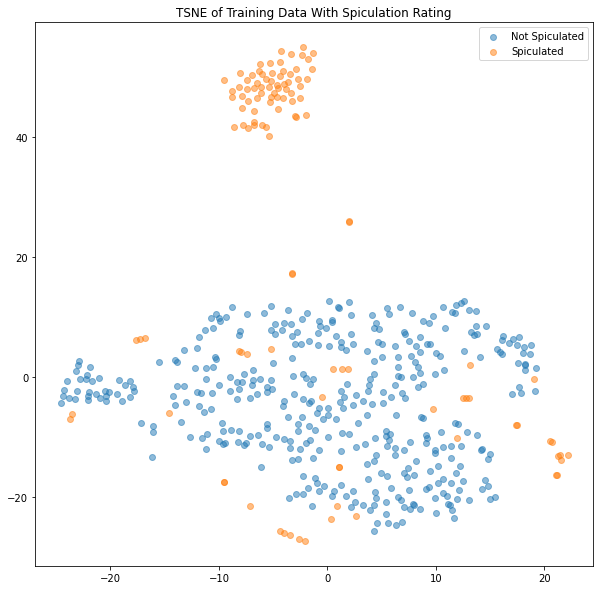

In [ ]:
###### Retrieve the embeddings, run KNN analysis, and print tsne for TRAINING DATA #####
# import training data
#train = pd.read_csv("/content/drive/MyDrive/MedIx REU/Datasets/TrainPixel.csv")
train = pd.read_csv("/content/drive/MyDrive/MedIx REU/Datasets/Amal/Lobulation/Train_Pixels.csv")

train_ids = (train['InstanceID']).values.tolist() #to list
train_label = train['Binary Rating']
train_label = pd.Series(train_label).array
train_images = train.drop(['InstanceID', "Binary Rating"], axis=1)
train_data = np.array(train_images).reshape(-1,71,71,1)
# get the embeddings and run KNN analysis
embeddings_raw1 = model.predict(train_data)
embeddings1 = (embeddings_raw1 - embeddings_raw1.min()) / (embeddings_raw1.max() - embeddings_raw1.min())

#Run KNN on the embeddings from TRAINING DATA
neigh = KNeighborsClassifier(n_neighbors=3, metric = 'cosine')
neigh.fit(embeddings1, train_label)
train_pred_class = neigh.predict(embeddings1)
# calculate the training data accuracy
accuracy_test = accuracy_score(y_true=train_label, y_pred=train_pred_class)
print("Train: ")
print(accuracy_test)

# print the TSNE graphs for the training data, along with it's ground truth label color
train_legend = ['Not Spiculated', 'Spiculated'] # 0 = Spiculated, 1 = Not Spiculated
X_embedded1 = TSNE(n_components=2,random_state=2).fit_transform(embeddings1)

og_tsne = plt.figure(figsize=(10,10))

for i in range(2):
  inds = np.where(train_label==i)[0]
  plt.scatter(X_embedded1[inds,0],X_embedded1[inds,1],alpha=0.5, color=colors[i])
  name0 = 'test case {}/tsne/train tsne'.format(run)
  plt.title('TSNE of Training Data With Spiculation Rating')
  plt.legend(train_legend)
# og_tsne.savefig(name0)

Validation: 
0.8174603174603174


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


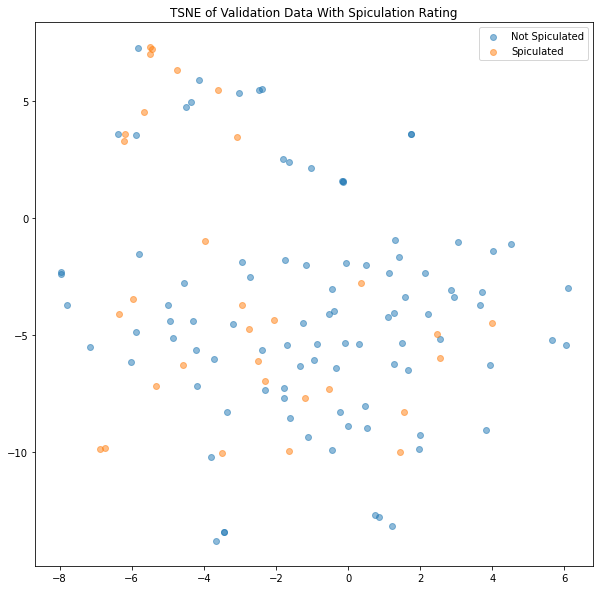

In [ ]:
###### Retrieve the embeddings, run KNN analysis, and print tsne for VALIDATION DATA#####
# import validation data
#validation = pd.read_csv("/content/drive/MyDrive/MedIx REU/Datasets/TestPixel.csv")
validation = pd.read_csv("/content/drive/MyDrive/MedIx REU/Datasets/Amal/Lobulation/Test_Pixels.csv")

validation_ids = (validation['InstanceID']).values.tolist() #to list
validation_label = validation['Binary Rating']
validation_label = pd.Series(validation_label).array
validation_images = validation.drop(['InstanceID', "Binary Rating"],  axis=1)
validation_data = np.array(validation_images).reshape(-1,71,71,1)

# get the embeddings and run KNN analysis
embeddings_raw2 = model.predict(validation_data)
embeddings2 = (embeddings_raw2 - embeddings_raw2.min()) / (embeddings_raw2.max() - embeddings_raw2.min())

neigh.fit(embeddings2, validation_label)
validation_pred_class = neigh.predict(embeddings2)

# calculate the validation data accuracy
accuracy_test = accuracy_score(y_true=validation_label, y_pred=validation_pred_class)
print("Validation: ")
print(accuracy_test)

# print the TSNE graph for validation data, along with it's ground truth label color
X_embedded2 = TSNE(n_components=2,random_state=2).fit_transform(embeddings2)
og_tsne1 = plt.figure(figsize=(10,10))
for i in range(2):
  inds = np.where(validation_label==i)[0]
  plt.scatter(X_embedded2[inds,0],X_embedded2[inds,1],alpha=0.5, color=colors[i])
  name1 = 'test case {}/tsne/validation tsne'.format(run)
  plt.title('TSNE of Validation Data With Spiculation Rating')
  plt.legend(train_legend)
# og_tsne1.savefig(name1)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


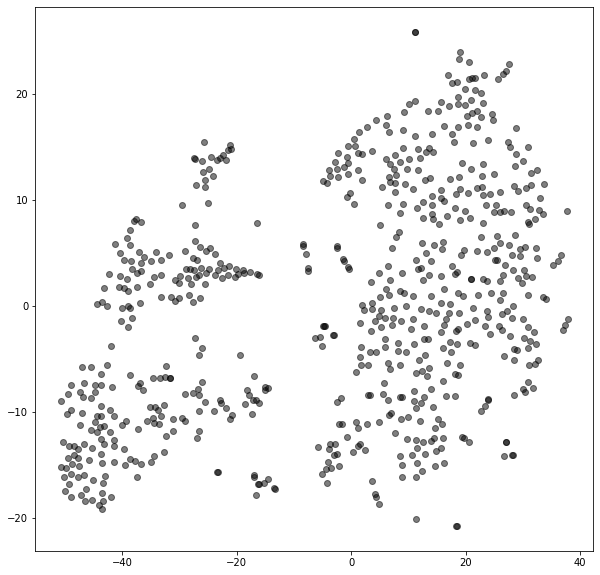

In [ ]:
###### Retrieve the embeddings, run KNN analysis, and print tsne for TESTING DATA#####
# Reading in the testing data
#test = pd.read_csv("/content/drive/MyDrive/MedIx REU/Datasets/TestingValsALL.csv")    #50 agree + no agree (all testing)
#test = pd.read_csv("/content/drive/MyDrive/MedIx REU/Datasets/TestingValsNOAgree.csv") #--no agree
#test = pd.read_csv("/content/drive/MyDrive/MedIx REU/Datasets/TestingVals50Agree.csv") #--50 agree
test = pd.read_csv("/content/drive/MyDrive/MedIx REU/Datasets/Amal/Lobulation/TestingValsALL.csv")
test_ids = test['InstanceID']
test_images = test.drop(['InstanceID'],  axis=1)
test_data = np.array(test_images).reshape(-1,71,71,1)
test_ids = np.array(test_ids) # length = 591

# get the embeddings and run KNN analysis
y_pred_test_before = model.predict(test_data)
y_pred_test = (y_pred_test_before - y_pred_test_before.min()) / (y_pred_test_before.max() - y_pred_test_before.min())

knn_pred = neigh.predict(y_pred_test)
knn_prob = neigh.predict_proba(y_pred_test)
# # print the TSNE graph for testing data, but without ground truth color, because there is none
X_embedded3 = TSNE(n_components=2,random_state=2).fit_transform(y_pred_test)
og_tsne = plt.figure(figsize=(10,10))
for i in range(len(X_embedded3)):
  plt.scatter(X_embedded3[i,0],X_embedded3[i,1],alpha=0.5, color='black')
  name2 = 'test case {}/tsne/test tsne'.format(run)
# og_tsne.savefig(name2)

In [ ]:
print(len(test_data))

704


In [ ]:
###### Retrieve the embeddings, run KNN analysis, and print tsne for TRAINING AND VALIDATION DATA COMBINED #####
# First, need to extract only training and validation indices from all data
#total_il = pd.read_csv("/content/drive/MyDrive/MedIx REU/Datasets/AllPixels - 2.csv")
total_il = pd.read_csv("/content/drive/MyDrive/MedIx REU/Datasets/Amal/Lobulation/AllPixels - 2.csv")
# We need only data with label = 2 because this is the combination of training and validation
for index, row in total_il.iterrows():
  if row['Dataset'] == 2: #drop the Testing data
    total_il.drop(index, inplace=True)
# Separate the full dataframe into parts
total2_ids = total_il['InstanceID']
print('Training data size:', len(total2_ids))
total2_label = total_il['Dataset'] # 1 = Training
total2_images = total_il.drop(['InstanceID','Dataset'],  axis=1)
total2_data = np.array(total2_images).reshape(-1,71,71,1)
total2_ids = np.array(total2_ids)
# Make a binary rating column corresponding to the training and val data
binary_il = []
for i in range(len(total2_images)):
  id = total2_ids[i]
  if id in validation_ids:
    indexk = validation_ids.index(id)
    binary = validation_label[indexk]
    binary_il.append(binary)
  if id in train_ids:
    indexk = train_ids.index(id)
    binary = train_label[indexk]
    binary_il.append(binary)

Training data size: 632


In [ ]:
len(total2_images)

632

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


(array([-30., -20., -10.,   0.,  10.,  20.,  30.]),
 <a list of 7 Text major ticklabel objects>)

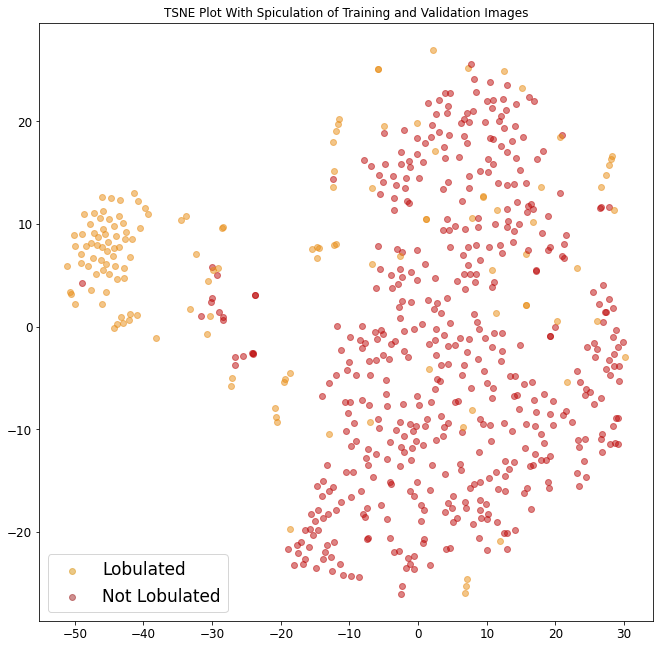

In [ ]:
# get the embeddings
total2_embeddings_before = model.predict(total2_data)
total2_embeddings = (total2_embeddings_before - total2_embeddings_before.min()) / (total2_embeddings_before.max() - total2_embeddings_before.min())
tot_embedded_il = TSNE(n_components=2,random_state=2).fit_transform(total2_embeddings)
# Training and validation tsne with spiculated and non-spiculated
spic_tsne = plt.figure(figsize=(11,11))
# Red, Orange & 0 = Spiculated, 1 = Not Spiculated. Therefore Red = Spiculated, & Orange = Non Spiculated
spic_legend2 = ['Lobulated', 'Not Lobulated']
for k in range(len(total2_images)):
  binary = binary_il[k]
  plt.scatter(tot_embedded_il[k, 0], tot_embedded_il[k, 1], alpha=0.5, color=radio_colors[binary])
plt.title('TSNE Plot With Spiculation of Training and Validation Images')
name9 = 'test case {}/tsne/spiculation tsne - trainval'.format(run)
plt.legend(spic_legend2, fontsize=17, loc=3)
ax = plt.gca()
leg = ax.get_legend()
leg.legendHandles[0].set_color('#d9920f')
leg.legendHandles[1].set_color('#9e2020')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
#spic_tsne.savefig(name9)

In [ ]:
##### Run all data (testing, training, and validation) to retrieve embeddings and plot tsne #####                               USE THIS ONE! :)
# read in file with all of the data
#total = pd.read_csv("/content/drive/MyDrive/MedIx REU/Datasets/AllPixels - 2.csv")
total = pd.read_csv("/content/drive/MyDrive/MedIx REU/Datasets/Amal/Lobulation/AllPixels - 2.csv")
total_ids = total['InstanceID']
dataset_label = total['Dataset'] # 1 = Training, 2 = Validation, 3 = Testing
total_images = total.drop(['InstanceID','Dataset'],  axis=1)
total_data = np.array(total_images).reshape(-1,71,71,1)
total_ids = np.array(total_ids)
print('Testing data size:', len(total_ids))
# get the embeddings
total_embeddings_before = model.predict(total_data)
total_embeddings2 = (total_embeddings_before - total_embeddings_before.min()) / (total_embeddings_before.max() - total_embeddings_before.min())
tot_embedded2 = TSNE(n_components=2,random_state=2).fit_transform(total_embeddings2)

Testing data size: 1336


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


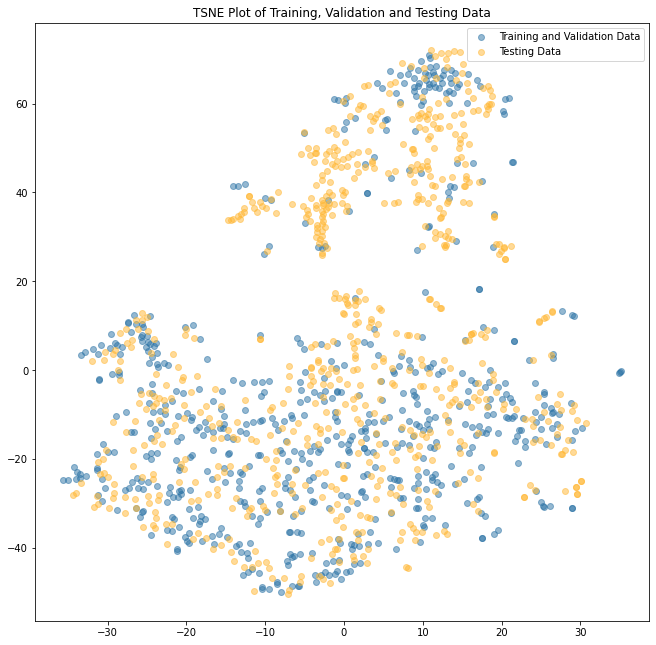

In [ ]:
## plotting the tsne with the colors according to the data (training vs testing)
    # blue = training and validation, orange = testing
lidc_classes = ['Training and Validation Data', 'Testing Data']
tot_tsne2_col = plt.figure(figsize=(11,11))
for i in range(2): #bc 2 is the number of classes (training vs testing)
  inds = np.where(dataset_label==(i+1))[0]
  plt.scatter(tot_embedded2[inds, 0], tot_embedded2[inds,1], alpha=0.5, color=radio_colors_mnist[i])
plt.title('TSNE Plot of Training, Validation and Testing Data')
plt.legend(lidc_classes, fontsize=10, loc=1)

name4 = 'test case {}/tsne/total tsne option 2 color'.format(run)
#tot_tsne2_col.savefig(name4)

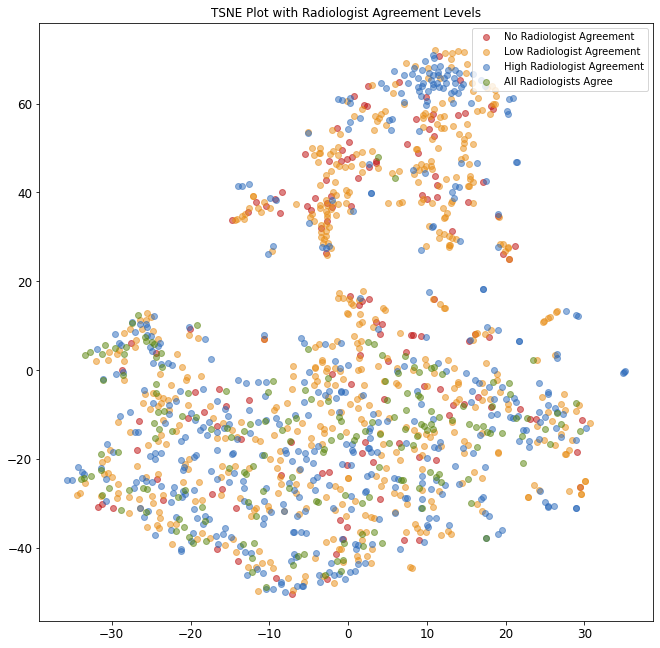

In [ ]:
## plotting the tsne with varying levels of radiologist disagreement
#radiologist = pd.read_csv("/content/drive/MyDrive/MedIx REU/LIDC Agreement Files/Everything_Agreements - integers.csv")
radiologist = pd.read_csv("/content/drive/MyDrive/MedIx REU/Datasets/Amal/Lobulation/Agreement_Binary_Rating.csv")
radio_ids = radiologist['InstanceID'] #pandas dataframe
radio_ids2 = radio_ids.values #list
agreements = radiologist['Agreement']
tsne_radio = plt.figure(figsize=(11,11))
radio_classes = [0, 1, 2, 3]
radio_names = ['No Radiologist Agreement', 'Low Radiologist Agreement', 'High Radiologist Agreement', 'All Radiologists Agree']

agreement_inds = []
agreement_id = []

for i in radio_classes:
  inds = np.where(agreements==i)
  plt.scatter(tot_embedded2[inds, 0], tot_embedded2[inds,1], alpha=0.5, color=radio_colors[i])
  ids = radio_ids2[inds]
  agreement_inds.append(inds)  # should be in the order of high agreement -> low agreement  # also, these are the index numbers
  agreement_id.append(ids)  # these are the instance id's
plt.title('TSNE Plot with Radiologist Agreement Levels')                                                                       # commented out title
#plt.title('(b)', fontweight="bold", fontsize=20, y=-0.1)
plt.legend(radio_names, fontsize=10, loc=1)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
name5 = 'test case {}/tsne/radiologist tsne'.format(run)
#tsne_radio.savefig(name5, bbox_inches='tight')

(array([-60., -40., -20.,   0.,  20.,  40.,  60.,  80.]),
 <a list of 8 Text major ticklabel objects>)

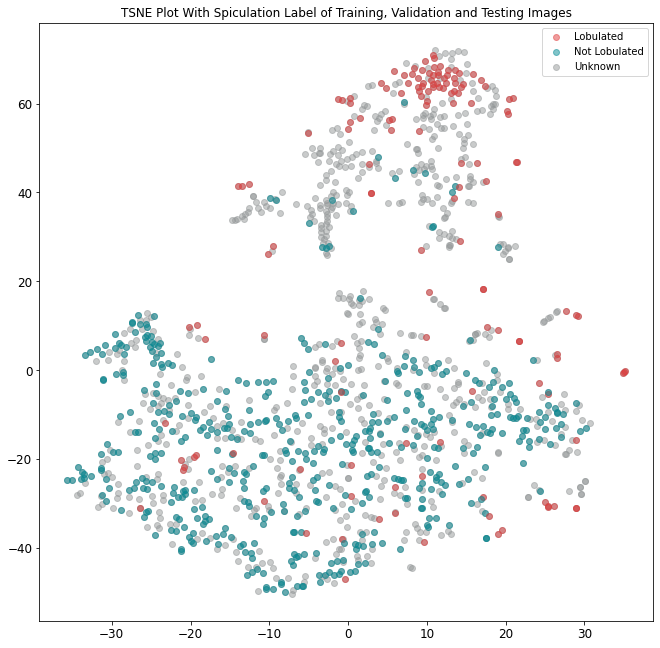

In [ ]:
## Print tsne with class labels (spic/non-spic) for training and validation data
spic_tsne = plt.figure(figsize=(11,11))
tot_train_data = np.concatenate((agreement_id[2], agreement_id[3]))
tot_train_inds = np.hstack((agreement_inds[2], agreement_inds[3]))[0]
spic_colors = ['#048a94','#e03d3d'] # RED, BLUE   # 0 = Spiculated, 1 = Not Spiculated
spic_legend = ['Lobulated','Not Lobulated', 'Unknown']

for i in range(len(tot_embedded2)):
   plt.scatter(tot_embedded2[i, 0], tot_embedded2[i, 1], alpha=0.5, color= '#949899')
for k in range(len(tot_train_data)):
  val = tot_train_data[k]
  emb_ind = tot_train_inds[k]
  if val in validation_ids:
    indexk = validation_ids.index(val)
    binary = validation_label[indexk]
    plt.scatter(tot_embedded2[emb_ind, 0], tot_embedded2[emb_ind, 1], alpha=0.5, color=spic_colors[binary])
  if val in train_ids:
    indexk = train_ids.index(val)
    binary = train_label[indexk]
    scatter = plt.scatter(tot_embedded2[emb_ind, 0], tot_embedded2[emb_ind, 1], alpha=0.5, color=spic_colors[binary])
plt.title('TSNE Plot With Spiculation Label of Training, Validation and Testing Images')                                                         # commented out title
#plt.title('(a)', fontweight="bold", fontsize=20, y=-0.1)
name9 = 'test case {}/tsne/spiculation tsne'.format(run)
plt.legend(spic_legend, fontsize=10, loc=1)
ax = plt.gca()
leg = ax.get_legend()
leg.legendHandles[0].set_color('#e03d3d')
leg.legendHandles[1].set_color('#048a94')
#plt.legend(handles=scatter.legend_elements()[0], labels=spic_legend, fontsize=17, loc=2)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
#spic_tsne.savefig(name9, bbox_inches='tight')

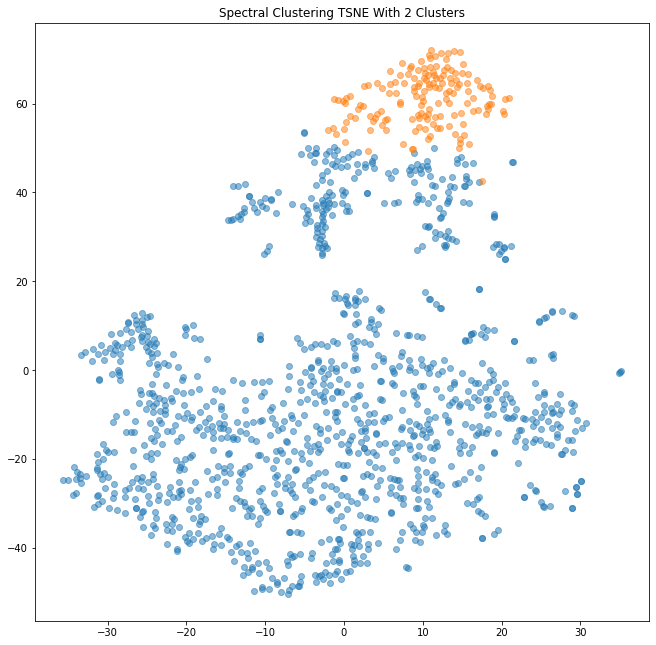

In [ ]:
##### Run spectral clustering on the embeddings for ALL of the data #####
numbers = [2] #[2, 3, 4, 5, 6] #number of clusters
silhouette_total = []
wss_total = []
spic_legend_Cls = ['Lobulated','Not Lobulated']
for numclusters in numbers:
  embeddings = total_embeddings2 #change depending on if we wanna run test cases vs all cases
  X_embedded = tot_embedded2 #change depending on if we wanna run test cases vs all cases
  sc = SpectralClustering(n_clusters=numclusters, random_state=0)
  y_sc = sc.fit_predict(embeddings)

  # plot the tsne with spectral clusters
  og_spectral = plt.figure(figsize=(11,11))
  for i in range(numclusters):
      inds = np.where(y_sc==i)[0]
      plt.scatter(X_embedded[inds,0],X_embedded[inds,1],alpha=0.5, color=colors[i])
  name3 = 'test case {}/{} cluster/spectral tsne'.format(run, numclusters)
  plt.title('Spectral Clustering TSNE With {} Clusters'.format(numclusters))
  #plt.legend(spic_legend_Cls, fontsize=17, loc=3)
  #ax = plt.gca()
  #leg = ax.get_legend()
  #leg.legendHandles[0].set_color('#ff7f0e')
  #leg.legendHandles[1].set_color('#a52a2a')

In [ ]:
##### Data Analysis: WSS & Silhouette #####
# Calculate centroids and WSS
centroids = cluster_centroid(embeddings, y_sc, numclusters)
wss_clusterlist, closest_ind_number, largest_ind_number = wss(centroids, embeddings, y_sc, numclusters, 0) # only want the 0 highest and lowest points -- because the clusters are so small this is necessary for now
silhouette = silhouette_score(embeddings, y_sc, metric = 'euclidean', random_state=9)
wss_total.append(wss_clusterlist) # for the wss elbow plot
silhouette_total.append(silhouette)

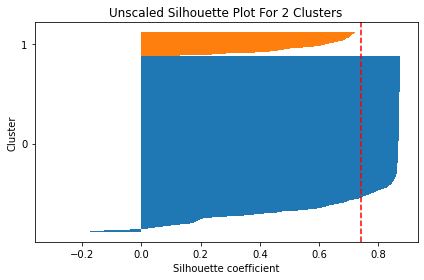

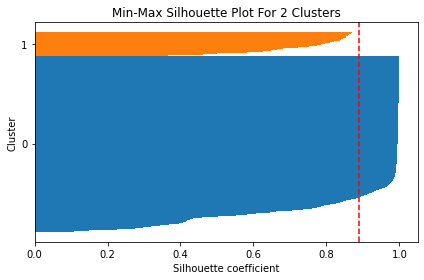

In [ ]:
# First, do all silhouette work on the raw embeddings
silhouette_valsb4 = silhouette_samples(embeddings, y_sc, metric='euclidean') # get the silhouette value per sample
silhouette_avgb4 = silhouette_plt(y_sc, silhouette_valsb4, run, numclusters, 0) # create and save the silhouette plot, and find the average of all of the silhouette scores
silhouette_clustersb4 = silhouette_cluster_average(y_sc, silhouette_valsb4, numclusters)
sil_clusterb4_avg = np.mean(silhouette_clustersb4) # average all of the averaged silhouette cluster scores
stdclustersb4 = np.std(silhouette_clustersb4) # find the standard deviation of the averaged silhouette cluster scores
sil_clus_arrayb4 = silhouette_cluster_array(y_sc, silhouette_clustersb4) # make the silhouette cluster an array corresponding to the image numbers
# Min Max all of the silhouette values, then repeat
scaler = MinMaxScaler()
silhouette_vals = scaler.fit_transform(silhouette_valsb4.reshape(-1,1))
silhouette_vals = silhouette_vals.flatten()
sil_avg_minmax = silhouette_plt(y_sc, silhouette_vals, run, numclusters, 1)
silhouette_clusters = silhouette_cluster_average(y_sc, silhouette_vals, numclusters)
sil_cluster_avg = np.mean(silhouette_clusters)
stdclusters = np.std(silhouette_clusters)
sil_clus_array = silhouette_cluster_array(y_sc, silhouette_clusters)


In [ ]:
# Apply the reverse metric to the silhouette coefficients
rev_silhouette_vals = silhouette_vals
actual_silhouette_vals = 1 - silhouette_vals

# Take the average of the scaled silhouette values
scaler = MinMaxScaler()
ci_avg = 1 - np.array([np.mean(k) for k in zip(silhouette_vals, sil_clus_array)])  ##  < to switch the metric backwards
ci_avg2 = np.array([np.mean(k) for k in zip(silhouette_vals, sil_clus_array)])  ## < for original metric (comparable to KNN)

# Multiply the scaled silhouette values
ci = 1 - (np.multiply(silhouette_vals, sil_clus_array))  ##  < to switch the metric backwards
ci_norm = scaler.fit_transform(ci.reshape(-1,1)) #< min max the confidence interval values
ci_norm = ci_norm.reshape(len(y_sc))
ci2 = np.multiply(silhouette_vals, sil_clus_array)  ##  < for original metric (comparable to KNN)
ci2_norm = scaler.fit_transform(ci2.reshape(-1,1)) #< min max the confidence interval values
ci2_norm = ci2_norm.reshape(len(y_sc))


In [ ]:
# Output to a file
dictionary = {'Image Number': total_ids, 'Sil Vals Scaled': actual_silhouette_vals, 'Rev Sil Vals Scaled': rev_silhouette_vals,
              'Avg Sil Metric': ci_avg, 'Rev Avg Sil Metric': ci_avg2,
              'Multiplied Sil Metric Scaled': ci_norm, 'Rev Multiplied Sil Metric Scaled': ci2_norm,
              'Sil Cluster Value Scaled': sil_clus_array, 'Clustered Class': y_sc}
data = pd.DataFrame(dictionary)
filename2 = 'test case {}/{} cluster/output file.xlsx'.format(run, numclusters)

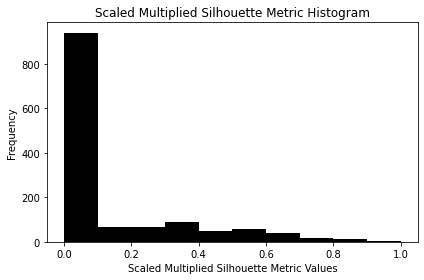

In [ ]:
## Plot histograms for the metrics
list_of_metrics = [ci_norm]
#list_of_metrics = [actual_silhouette_vals, ci_avg, ci_norm]
for q in range(len(list_of_metrics)):
    save_hist(list_of_metrics[q], metric_names[q], run, numclusters)

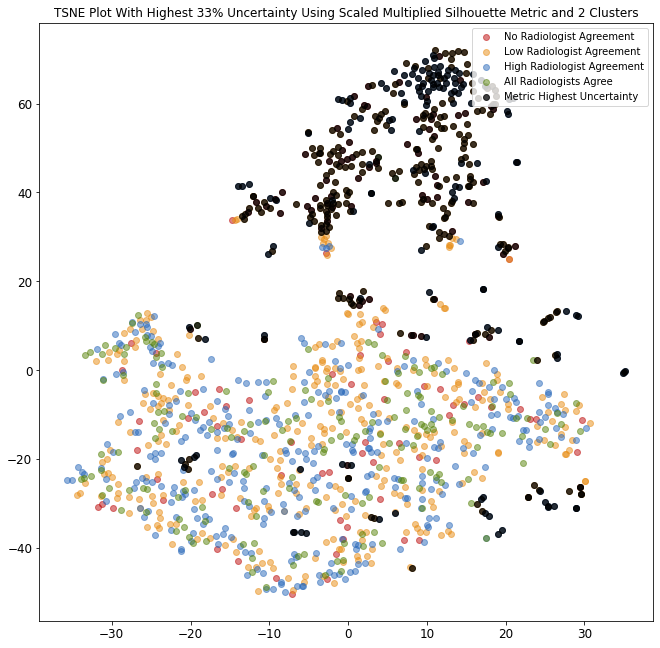

In [ ]:
for m in range(len(list_of_metrics)):
    newlegend = ['No Radiologist Agreement', 'Low Radiologist Agreement', 'High Radiologist Agreement', 'All Radiologists Agree', 'Metric Highest Uncertainty']
    newlistnum = [441] #33% #[353, 706] #25%, 50%

    for r in newlistnum:
      indlargest = np.argpartition(list_of_metrics[m], -r)[-r:]
      new1 = plt.figure(figsize=(11,11))
      for i in radio_classes:
        inds = np.where(agreements==i)
        plt.scatter(tot_embedded2[inds, 0], tot_embedded2[inds,1], alpha=0.5, color=radio_colors[i])
      for k in indlargest:
        plt.scatter(X_embedded[k,0], X_embedded[k,1], alpha=0.75, color = 'black')
      title2 = 'TSNE Plot With Highest {}% Uncertainty Using {}and {} Clusters'.format(str(round(r/(len(y_sc))*100)), metric_names[m], numclusters)
      plt.title(title2)                                                                                                                              # commented out title
      #plt.title('(c)', fontweight="bold", fontsize=20, y=-0.1)
      plt.xticks(fontsize=12)
      plt.yticks(fontsize=12)
      plt.legend(newlegend, fontsize=10, loc=1)
      plt.show()
      name8 = 'test case {}/{} cluster/RADIO - {}% highest uncertainty - {} clusters - {}'.format(run, numclusters, str(round(r/(len(y_sc))*100)), numclusters, metric_names[m])
      #new1.savefig(name8, bbox_inches='tight')

In [ ]:
list_of_metrics

[array([0.00504446, 0.00351846, 0.01400196, ..., 0.00046289, 0.300498  ,
        0.00107205])]

In [ ]:
len(list_of_metrics)

1

In [ ]:
newlistnum

[441]

In [ ]:
## This is to show the uncertainty points with only the All & high agreements
'''
combined_arr = []
combined_arr1 = []
tsne_radio = plt.figure(figsize=(11,11))
for m in range(len(list_of_metrics)):
    newlegend = ['High Radiologist Agreement', 'All Radiologists Agree']
    newlistnum = [650] #33% #[353, 706] #25%, 50%
    radio_classes = [2, 3]
    for r in newlistnum:
      indlargest = np.argpartition(list_of_metrics[m], -r)[-r:]
      new1 = plt.figure(figsize=(11,11))

      #for i in radio_classes:
      inds2 = np.where(agreements==2)
      plt.scatter(X_embedded[inds2, 0], X_embedded[inds2,1], alpha=0.5, color=radio_colors[2])
      inds3 = np.where(agreements==3)
      plt.scatter(X_embedded[inds3, 0], X_embedded[inds3,1], alpha=0.5, color=radio_colors[3])
      arr2 = inds2[0]
      arr3 = inds3[0]
      combined_arr= np.concatenate((arr2,arr3))

      for x in indlargest:
        if x in combined_arr: combined_arr1.append(x)
      #[k_elem for k_elem, inds_elem in (zip(indlargest, inds)) if k_elem == inds_elem[k_elem]]

      #for k in combined_arr1:
        #plt.scatter(X_embedded[k,0], X_embedded[k,1], alpha=0.75, color = 'black')
      title2 = 'TSNE Plot With Highest {}% Uncertainty Using {}and {} Clusters'.format(str(round(r/(len(y_sc))*100)), metric_names[m], numclusters)
      #plt.title(title2)                                                                                                                              # commented out title
      #plt.title('(c)', fontweight="bold", fontsize=20, y=-0.1)
      plt.xticks(fontsize=12)
      plt.yticks(fontsize=12)
      plt.legend(newlegend, fontsize=13, loc=2)
      plt.show()
      name8 = 'test case {}/{} cluster/RADIO - {}% highest uncertainty - {} clusters - {}'.format(run, numclusters, str(round(r/(len(y_sc))*100)), numclusters, metric_names[m])
      '''
      #new1.savefig(name8, bbox_inches='tight')

'\ncombined_arr = []\ncombined_arr1 = []\ntsne_radio = plt.figure(figsize=(11,11))\nfor m in range(len(list_of_metrics)):\n    newlegend = [\'High Radiologist Agreement\', \'All Radiologists Agree\']\n    newlistnum = [650] #33% #[353, 706] #25%, 50%\n    radio_classes = [2, 3]\n    for r in newlistnum:\n      indlargest = np.argpartition(list_of_metrics[m], -r)[-r:]\n      new1 = plt.figure(figsize=(11,11))\n    \n      #for i in radio_classes:\n      inds2 = np.where(agreements==2)\n      plt.scatter(X_embedded[inds2, 0], X_embedded[inds2,1], alpha=0.5, color=radio_colors[2]) \n      inds3 = np.where(agreements==3)\n      plt.scatter(X_embedded[inds3, 0], X_embedded[inds3,1], alpha=0.5, color=radio_colors[3]) \n      arr2 = inds2[0]\n      arr3 = inds3[0]\n      combined_arr= np.concatenate((arr2,arr3))\n        \n      for x in indlargest:\n        if x in combined_arr: combined_arr1.append(x)\n      #[k_elem for k_elem, inds_elem in (zip(indlargest, inds)) if k_elem == inds_elem[k_

In [ ]:
## Number of Images in Overlap
# amounts = [141, 466, 706] #%~10%, 33%, 50%
# percentages = ['10%', '33%', '50%']
amounts = list(range(133, 441, 5)) #5% - ~50%
percentages = []
for i in amounts:
  a = str(round((i/1336), 3)) + '%'
  percentages.append(a)
for j in range(len(list_of_metrics)):
  acc_df = {'Metric Highest Uncertainty %': percentages}
  for l in radio_classes:  #[0, 1, 2, 3] = Lowest ---> Highest Agreement
    acc = radio_comparison(agreement_id, list_of_metrics[j], amounts, l)
    acc_df[radio_names[l]] = acc
  combination = np.add((acc_df['No Radiologist Agreement']), (acc_df['Low Radiologist Agreement']))
  acc_df['No & Low Combination'] = combination
  combination2 = np.add((acc_df['High Radiologist Agreement']), (acc_df['All Radiologists Agree']))
  acc_df['All & High Combination'] = combination2
  acc_df = pd.DataFrame(acc_df)
  sheet_names = '{} - Total Number'.format(numclusters)
  #acc_df.to_excel(writer_list[j], sheet_name = sheet_names, index = True)

## Accuracy (divided by number of images per category (low, high, none, etc.))
for j in range(len(list_of_metrics)):
  acc_df1 = {'Metric Highest Uncertainty %': percentages}
  for l in radio_classes:  #[0, 1, 2, 3] = Lowest ---> Highest Agreement
    acc = radio_comparison2(agreement_id, list_of_metrics[j], amounts, l)
    acc_df1[radio_names[l]]= acc
  acc_combination = combination/591 #total number of low and no cases
  acc_df1['No & Low Combination'] = acc_combination
  acc_combination2 = combination2/822 #total number of all and high cases
  acc_df1['All & High Combination'] = acc_combination2
  acc_df1 = pd.DataFrame(acc_df1)
  sheet_names = '{} - Over Radio Total'.format(numclusters)
  acc_df1.to_excel(writer_list[j], sheet_name = sheet_names, index = True)

  # Find the most uncertain images each run -- using multiplication
  mostuncertain = np.argpartition(ci_norm, -10)[-10:]
  uncertain_images = total_ids[mostuncertain]
  # plt.imshow(uncertain_images[0], cmap = 'gray')
print("DONE")

DONE


In [ ]:
##### Run spectral clustering on the embeddings for ALL of the data #####
'''numbers = [2] #[2, 3, 4, 5, 6]
silhouette_total = []
wss_total = []
for numclusters in numbers:
  embeddings = total_embeddings2 #change depending on if we wanna run test cases vs all cases
  X_embedded = tot_embedded2 #change depending on if we wanna run test cases vs all cases
  sc = SpectralClustering(n_clusters=numclusters, random_state=0)
  y_sc = sc.fit_predict(embeddings)

  # plot the tsne with spectral clusters
  og_spectral = plt.figure(figsize=(10,10))
  for i in range(numclusters):
      inds = np.where(y_sc==i)[0]
      plt.scatter(X_embedded[inds,0],X_embedded[inds,1],alpha=0.5, color=colors[i])
  name3 = 'test case {}/{} cluster/spectral tsne'.format(run, numclusters)
  plt.title('Spectral Clustering TSNE With {} CLusters'.format(numclusters))
  #og_spectral.savefig(name3)

  ##### Data Analysis: WSS & Silhouette #####
  # Calculate centroids and WSS
  centroids = cluster_centroid(embeddings, y_sc, numclusters)
  wss_clusterlist, closest_ind_number, largest_ind_number = wss(centroids, embeddings, y_sc, numclusters, 0) # only want the 0 highest and lowest points -- because the clusters are so small this is necessary for now
  silhouette = silhouette_score(embeddings, y_sc, metric = 'euclidean', random_state=9)
  wss_total.append(wss_clusterlist) # for the wss elbow plot
  silhouette_total.append(silhouette)

  # First, do all silhouette work on the raw embeddings
  silhouette_valsb4 = silhouette_samples(embeddings, y_sc, metric='euclidean') # get the silhouette value per sample
  silhouette_avgb4 = silhouette_plt(y_sc, silhouette_valsb4, run, numclusters, 0) # create and save the silhouette plot, and find the average of all of the silhouette scores
  silhouette_clustersb4 = silhouette_cluster_average(y_sc, silhouette_valsb4, numclusters)
  sil_clusterb4_avg = np.mean(silhouette_clustersb4) # average all of the averaged silhouette cluster scores
  stdclustersb4 = np.std(silhouette_clustersb4) # find the standard deviation of the averaged silhouette cluster scores
  sil_clus_arrayb4 = silhouette_cluster_array(y_sc, silhouette_clustersb4) # make the silhouette cluster an array corresponding to the image numbers
  # Min Max all of the silhouette values, then repeat
  scaler = MinMaxScaler()
  silhouette_vals = scaler.fit_transform(silhouette_valsb4.reshape(-1,1))
  silhouette_vals = silhouette_vals.flatten()
  sil_avg_minmax = silhouette_plt(y_sc, silhouette_vals, run, numclusters, 1)
  silhouette_clusters = silhouette_cluster_average(y_sc, silhouette_vals, numclusters)
  sil_cluster_avg = np.mean(silhouette_clusters)
  stdclusters = np.std(silhouette_clusters)
  sil_clus_array = silhouette_cluster_array(y_sc, silhouette_clusters)

  # Calculate other clustering metrics, trying S_dbw and SD --- google colab does not have module, may have to pip install?
  # s_dbw_score = S_Dbw(embeddings, y_sc)
  # sd_score = SD(embeddings, y_sc)

  # Writing to a file (It was commented)
  filename = 'test case {}/{} cluster/data analysis'.format(run, numclusters)
  f = open(filename, "w")
  f.write('Silhouette Values Before Min Max Scaling:\n')
  f.write('Silhouette Average of All Values Before Min Max Scaling (Red Line On Plot): {}\n'.format(silhouette_avgb4))
  f.write('Silhouette Average of All Cluster Averages Before Min Max Scaling: {}\n'.format(sil_clusterb4_avg))
  f.write('Silhouette Clusters Standard Deviation Before Min Max Scaling: {}\n\n'.format(stdclustersb4))
  f.write('Silhouette Values After Min Max Scaling:\n')
  f.write('Silhouette Average of All Values After Min Max Scaling (Red Line On Plot): {}\n'.format(sil_avg_minmax))
  f.write('Silhouette Average of All Cluster Averages After Min Max Scaling: {}\n'.format(sil_cluster_avg))
  f.write('Silhouette Clusters Standard Deviation After Min Max Scaling: {}\n'.format(stdclusters))
  #f.write('\nOther Clustering Metrics:')
  #f.write('\nS-DBW Validitiy Index Score: {}\n'.format(s_dbw_score))
  #f.write('\nSD Validity Index Score: {}\n'.format(sd_score))
  f.close()

  # Apply the reverse metric to the silhouette coefficients
  rev_silhouette_vals = silhouette_vals
  actual_silhouette_vals = 1 - silhouette_vals

  # Take the average of the scaled silhouette values
  scaler = MinMaxScaler()
  ci_avg = 1 - np.array([np.mean(k) for k in zip(silhouette_vals, sil_clus_array)])  ##  < to switch the metric backwards
  ci_avg2 = np.array([np.mean(k) for k in zip(silhouette_vals, sil_clus_array)])  ## < for original metric (comparable to KNN)

  # Multiply the scaled silhouette values
  ci = 1 - (np.multiply(silhouette_vals, sil_clus_array))  ##  < to switch the metric backwards
  ci_norm = scaler.fit_transform(ci.reshape(-1,1)) #< min max the confidence interval values
  ci_norm = ci_norm.reshape(len(y_sc))
  ci2 = np.multiply(silhouette_vals, sil_clus_array)  ##  < for original metric (comparable to KNN)
  ci2_norm = scaler.fit_transform(ci2.reshape(-1,1)) #< min max the confidence interval values
  ci2_norm = ci2_norm.reshape(len(y_sc))

  # Output to a file
  dictionary = {'Image Number': total_ids, 'Sil Vals Scaled': actual_silhouette_vals, 'Rev Sil Vals Scaled': rev_silhouette_vals,
                'Avg Sil Metric': ci_avg, 'Rev Avg Sil Metric': ci_avg2,
                'Multiplied Sil Metric Scaled': ci_norm, 'Rev Multiplied Sil Metric Scaled': ci2_norm,
                'Sil Cluster Value Scaled': sil_clus_array, 'Clustered Class': y_sc}
  data = pd.DataFrame(dictionary)
  filename2 = 'test case {}/{} cluster/output file.xlsx'.format(run, numclusters)
  #data.to_excel(filename2)

  ## Plot histograms for the metrics
  list_of_metrics = [ci_norm]
  #list_of_metrics = [actual_silhouette_vals, ci_avg, ci_norm]
  for q in range(len(list_of_metrics)):
      save_hist(list_of_metrics[q], metric_names[q], run, numclusters)

  # ## Plot all points above 50% for all of the evaluation metrics
  # for m in range(len(list_of_metrics)):
  #     leastinds = np.where(list_of_metrics[m] > 0.5)[0]
  #     newleast1 = plt.figure(figsize=(10,10))
  #     for i in range(numclusters):
  #         inds = np.where(y_sc==i)[0]
  #         plt.scatter(X_embedded[inds,0], X_embedded[inds,1], alpha=0.5, color=colors[i])
  #     for l in leastinds:
  #         plt.scatter(X_embedded[l,0], X_embedded[l,1], color = 'black')
  #     title1 = 'TSNE Plot With {} Clusters and >0.5 Degree Uncertainty With {}'.format(numclusters, metric_names[m])
  #     plt.title(title1)
  #     plt.show()
  #     name1 = 'test case {}/{} cluster/above  0.5 {} - {} clusters.png'.format(run, numclusters, metric_names[m], numclusters)
  #     newleast1.savefig(name1)

  # ## Plot the highest 10% and 20% uncertainty of images - only 20% for now
  # listnum = [282]
  # for m in range(len(list_of_metrics)):
  #     for r in listnum:
  #         indlargest = np.argpartition(list_of_metrics[m], -r)[-r:]
  #         most = plt.figure(figsize=(10,10))
  #         for i in range(numclusters):
  #             inds = np.where(y_sc==i)[0]
  #             plt.scatter(X_embedded[inds,0], X_embedded[inds,1], alpha=0.5, color=colors[i])
  #         for l in indlargest:
  #             plt.scatter(X_embedded[l,0], X_embedded[l,1], color = 'black')
  #         title1 = 'TSNE Plot With {} Clusters and {}% Highest Uncertainty Points With {}'.format(numclusters, str(round(r/(len(y_sc))*100)), metric_names[m])
  #         plt.title(title1)
  #         plt.show()
  #         name1 = 'test case {}/{} cluster/{} highest uncertainty - {} clusters - {}'.format(run, numclusters, r, numclusters, metric_names[m])
  #         most.savefig(name1)

  for m in range(len(list_of_metrics)):
    newlegend = ['No Radiologist Agreement', 'Low Radiologist Agreement', 'High Radiologist Agreement', 'All Radiologists Agree', 'Metric Highest Uncertainty']
    newlistnum = [466] #33% #[353, 706] #25%, 50%
    for r in newlistnum:
      indlargest = np.argpartition(list_of_metrics[m], -r)[-r:]
      new1 = plt.figure(figsize=(11,11))
      for i in radio_classes:
        inds = np.where(agreements==i)
        plt.scatter(tot_embedded2[inds, 0], tot_embedded2[inds,1], alpha=0.5, color=radio_colors[i])
      for k in indlargest:
        plt.scatter(X_embedded[k,0], X_embedded[k,1], alpha=0.75, color = 'black')
      title2 = 'TSNE Plot With Highest {}% Uncertainty Using {}and {} Clusters'.format(str(round(r/(len(y_sc))*100)), metric_names[m], numclusters)
      #plt.title(title2)                                                                                                                              # commented out title
      #plt.title('(c)', fontweight="bold", fontsize=20, y=-0.1)
      plt.xticks(fontsize=12)
      plt.yticks(fontsize=12)
      plt.legend(newlegend, fontsize=13, loc=2)
      plt.show()
      name8 = 'test case {}/{} cluster/RADIO - {}% highest uncertainty - {} clusters - {}'.format(run, numclusters, str(round(r/(len(y_sc))*100)), numclusters, metric_names[m])
      #new1.savefig(name8, bbox_inches='tight')

  ## Number of Images in Overlap
  # amounts = [141, 466, 706] #%~10%, 33%, 50%
  # percentages = ['10%', '33%', '50%']
  amounts = list(range(70, 1400, 5)) #5% - ~50%
  percentages = []
  for i in amounts:
    a = str(round((i/1412), 3)) + '%'
    percentages.append(a)
  for j in range(len(list_of_metrics)):
    acc_df = {'Metric Highest Uncertainty %': percentages}
    for l in radio_classes:  #[0, 1, 2, 3] = Lowest ---> Highest Agreement
      acc = radio_comparison(agreement_id, list_of_metrics[j], amounts, l)
      acc_df[radio_names[l]] = acc
    combination = np.add((acc_df['No Radiologist Agreement']), (acc_df['Low Radiologist Agreement']))
    acc_df['No & Low Combination'] = combination
    combination2 = np.add((acc_df['High Radiologist Agreement']), (acc_df['All Radiologists Agree']))
    acc_df['All & High Combination'] = combination2
    acc_df = pd.DataFrame(acc_df)
    sheet_names = '{} - Total Number'.format(numclusters)
    #acc_df.to_excel(writer_list[j], sheet_name = sheet_names, index = True)

  ## Accuracy (divided by number of images per category (low, high, none, etc.))
  for j in range(len(list_of_metrics)):
    acc_df1 = {'Metric Highest Uncertainty %': percentages}
    for l in radio_classes:  #[0, 1, 2, 3] = Lowest ---> Highest Agreement
      acc = radio_comparison2(agreement_id, list_of_metrics[j], amounts, l)
      acc_df1[radio_names[l]]= acc
    acc_combination = combination/591 #total number of low and no cases
    acc_df1['No & Low Combination'] = acc_combination
    acc_combination2 = combination2/822 #total number of all and high cases
    acc_df1['All & High Combination'] = acc_combination2
    acc_df1 = pd.DataFrame(acc_df1)
    sheet_names = '{} - Over Radio Total'.format(numclusters)
    acc_df1.to_excel(writer_list[j], sheet_name = sheet_names, index = True)

    # Find the most uncertain images each run -- using multiplication
    mostuncertain = np.argpartition(ci_norm, -10)[-10:]
    uncertain_images = total_ids[mostuncertain]
    # plt.imshow(uncertain_images[0], cmap = 'gray')

#writer1.save()
#writer2.save()
#writer3.save()
'''
#Extra Notes

# # OPTION 1:
# total_embeddings = np.vstack((embeddings1, embeddings2, y_pred_test)) # length = 1412
# print(len(total_embeddings))
# tot_embedded = TSNE(n_components=2,random_state=2).fit_transform(total_embeddings)
# tot_tsne = plt.figure(figsize=(10,10))
# for i in range(len(tot_embedded)):
#     plt.scatter(tot_embedded[i,0],tot_embedded[i,1],alpha=0.5, color='black')
# name2 = 'test case {}/tsne/total tsne'.format(run)
# tot_tsne.savefig(name2)
'''

print("DONE")'''

'\n\nprint("DONE")'

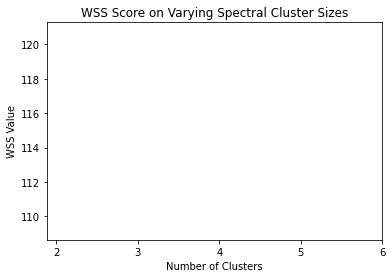

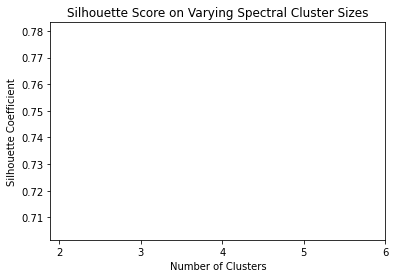

In [ ]:
# Only run this block if the above block runs through several numbers of clusters
##### Plot the silhouette and WSS elbow plots #####
# WSS Plot
wss_plot = plt.figure()
plt.plot(numbers, wss_total, color='blue', linewidth=2)
plt.title('WSS Score on Varying Spectral Cluster Sizes')
plt.xticks(np.linspace(2, 6, num=5))                  ## this is hard coded -- change depending on number of clusters run through
plt.xlabel('Number of Clusters')
plt.ylabel('WSS Value')
plt.show()
name6 = 'test case {}/WSS and Sil/wss error plot'.format(run)
#wss_plot.savefig(name6)
# Silhouette Plot
sil_plot = plt.figure()
plt.plot(numbers, silhouette_total, color='blue', linewidth=2)
plt.title('Silhouette Score on Varying Spectral Cluster Sizes')
plt.xticks(np.linspace(2, 6, num=5))                   ## this is hard coded -- change depending on number of clusters run through
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Coefficient')
plt.show()
name7 = 'test case {}/WSS and Sil/silhouette plot'.format(run)
#sil_plot.savefig(name7)


In [ ]:
###### Area evaluation #####
# lost this code, since we aren't going to use it in the paper, im not going to rewrite the whole thing...
area_data = pd.read_csv("/content/drive/MyDrive/MedIx REU/Datasets/Amal/LIDC_20130817_AllFeatures2D_AllSlices.csv")
area_ints = area_data['Area'].tolist()
area_ids = area_data['InstanceID'].tolist()
print(len(area_data))

39548


In [ ]:
##### Train, Val, Test evaluation #####
"""total_vis = pd.read_csv("/content/drive/MyDrive/MedIx REU/Datasets/Amal/Lobulation/Agreement_Binary_Rating_T.csv")
print(len(total_vis))
vis_ids = total_vis['InstanceID'].tolist()
vis_tr_te = total_vis['Agreement'].tolist()"""

'total_vis = pd.read_csv("/content/drive/MyDrive/MedIx REU/Datasets/Amal/Lobulation/Agreement_Binary_Rating_T.csv")\nprint(len(total_vis))\nvis_ids = total_vis[\'InstanceID\'].tolist()\nvis_tr_te = total_vis[\'Agreement\'].tolist()'

In [ ]:
##### Spiculation rate from all the training data (training and validation) #####
total_Spic = pd.read_csv("/content/drive/MyDrive/MedIx REU/Datasets/Amal/Lobulation/Agreement_Binary_Rating.csv")
print(len(total_Spic))
spic_ids = total_Spic['InstanceID'].tolist()
spic_tr_val = total_Spic['Binary Rating'].tolist()
vis_tr_te = total_Spic['Agreement'].tolist()
#category = total_Spic['Category'].tolist()

1336


In [ ]:
##### Highest Uncertainty Points #####

## obtain highest uncertainty indices
unc_index = np.argpartition(ci_norm, -1336)[-1336:] #3742
unc_values = ci_norm[unc_index]
unc_ids = total_ids[unc_index]
unc_imgs = total_data[unc_index]

## determine radiologist agreement per image
# already defined variables:
  # radio_classes = [0, 1, 2, 3]
  # radio_names = ['No Radiologist Agreement', 'Low Radiologist Agreement', 'High Radiologist Agreement', 'All Radiologists Agree']
  # agreement_id - these are the instance id's

# fix the agreement id variable to be iterable...
agreement_id2 = []
agreement_levels = []
counter = 0
for a in agreement_id:
  for k in a:
    agreement_id2.append(k)
    agreement_levels.append(counter)
  counter += 1

# retrieve vals for specific ids (highest uncertainty ids)
uncertainty_agreement = []
uncertainty_names = []

for k in unc_ids:
  agr_index = agreement_id2.index(k)
  unc_agr = agreement_levels[agr_index]
  unc_agr2= radio_names[unc_agr]

  uncertainty_agreement.append(unc_agr)
  uncertainty_names.append(unc_agr2)

## get the areas for each image
unc_areas = []
for j in unc_ids:
  if j in area_ids:
    area_index = area_ids.index(j)
    act_area = area_ints[area_index]
    unc_areas.append(act_area)

######### ---Amal--- #########
## get train and test label for each image
all_vis = []
for j in unc_ids:
  if j in spic_ids:
    tr_te_index = spic_ids.index(j)
    act_tr_te = vis_tr_te[tr_te_index]
    all_vis.append(act_tr_te)

## get spiculation rating for each image
spic_rate = []
instance_id = []
for j in unc_ids:
  if j in spic_ids:
    spic_index = spic_ids.index(j)
    spic_r = spic_tr_val[spic_index]
    spic_rate.append(spic_r)
    instance_id.append(j)
## get category for each image
cat = []
'''for j in unc_ids:
  if j in spic_ids:
    spic_index = spic_ids.index(j)
    cat_r = category[spic_index]
    cat.append(cat_r)'''


######### ---Amal--- #########


## print out each image
counter = 0

#To get uncertinaty scores for distrbution
num = []
agre = []
siz = []
tr_te = []
spic = []
cat_t = []
inst_id = []

for l in range(len(unc_imgs)):
  new_l = unc_imgs[l].reshape(71,71)
  actual_unc = unc_values[l]
  num.append(actual_unc)
  unc_name = uncertainty_names[l]
  agre.append(unc_name)
  area_act = unc_areas[l]
  siz.append(area_act)
  ######### ---Amal--- #########
  #cat_unc = cat[l]
  #cat_t.append(cat_unc)
  tr_te_unc = all_vis[l]
  tr_te.append(tr_te_unc)
  spic_unc = spic_rate[l]
  spic.append(spic_unc)
  id_inst = instance_id[l]
  inst_id.append(id_inst)

  '''unc_fig = plt.figure()
  plt.imshow(new_l,cmap='gray')
  plt.xticks([])
  plt.yticks([])
  unc_title = 'Uncertainty Score: {}\n{}\nSize: {}'.format(round(actual_unc, 4), unc_name, area_act)
  plt.title(unc_title, y=-0.25)
  name16 = 'test case {}/highest uncertainty/{}'.format(run, counter)
  #unc_fig.savefig(name16, bbox_inches='tight')
  counter += 1 '''

In [ ]:
print(len(unc_ids))

1336


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


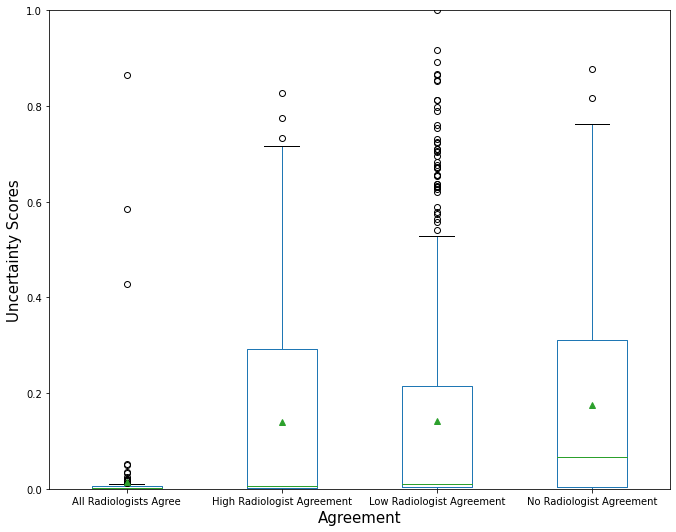

"import seaborn as sns\ng = sns.boxplot(x=df['Agreement'], y=df['Score'], data=df) \n#handles, _ = ax.get_legend_handles_labels()          # Get the artists.\n#g.legend(handles, ['training', 'testing'], loc=1)\nplt.show(g)"

In [ ]:
data = {'InstanceID': inst_id,
        'Score': num,
        'Agreement': agre,
        'Lobulation':spic,
        'Size': siz}
        #'Category': cat_t}

# Convert the dictionary into DataFrame
df = pd.DataFrame(data)

plt.rcParams["figure.figsize"] = [9.50, 7.50]
plt.rcParams["figure.autolayout"] = True
#df.plot(figsize=(20,20))

axes = df.boxplot(by='Agreement',column =['Score'], showmeans=True, showfliers=True, grid= False)
axes.set_title('')
plt.title('')
plt.suptitle('')
plt.ylim([0.0, 1.0])
plt.ylabel("Uncertainty Scores", fontdict={'fontsize':15})
plt.xlabel("Agreement", fontdict={'fontsize':15})
plt.show()
'''import seaborn as sns
g = sns.boxplot(x=df['Agreement'], y=df['Score'], data=df)
#handles, _ = ax.get_legend_handles_labels()          # Get the artists.
#g.legend(handles, ['training', 'testing'], loc=1)
plt.show(g)'''

In [ ]:
np.savetxt("/content/drive/MyDrive/MedIx REU/Datasets/Amal/Lobulation/max_scores.csv", df, fmt= "%s", delimiter=',')

In [ ]:
m2 = df.groupby(['Agreement'])['Score'].mean().values
print(m2)

[0.01503478 0.13947545 0.14119527 0.17593599]


In [ ]:
m1 = df.groupby(['Agreement'])['Score'].median().values
print(m1)

[0.00268614 0.00571644 0.01048446 0.06610905]


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


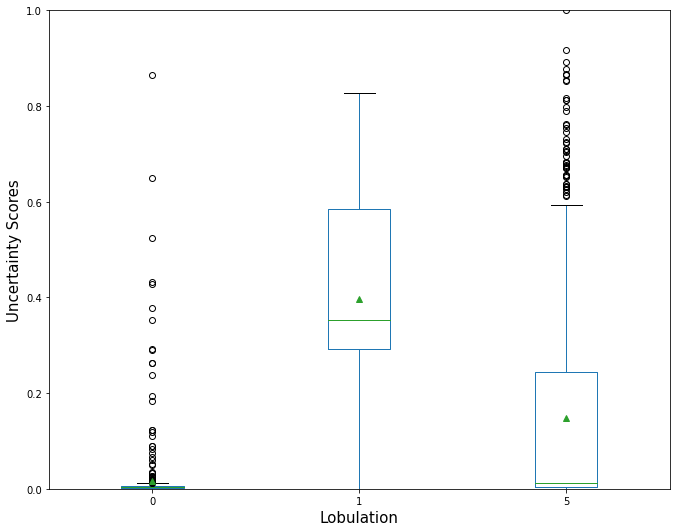

In [ ]:
plt.rcParams["figure.figsize"] = [9.50, 7.50]
plt.rcParams["figure.autolayout"] = True
#df.plot(figsize=(20,20))

axes = df.boxplot(by='Lobulation',column =['Score'], showmeans=True, showfliers=True, grid= False)
axes.set_title('')
plt.title('')
plt.suptitle('')
plt.ylim([0.0, 1.0])
plt.ylabel("Uncertainty Scores", fontdict={'fontsize':15})
plt.xlabel("Lobulation", fontdict={'fontsize':15})
#plt.xticks([1, 2, 3], ['Not Lobulated', 'Lobulated', 'Unknown'])
plt.show()

In [ ]:
m1 = df.groupby(['Lobulation'])['Score'].mean().values
print(m1)

[0.01732835 0.39700338 0.14810394]


In [ ]:
m1 = df.groupby(['Lobulation'])['Score'].median().values
print(m1)

[0.00328714 0.35349864 0.01265579]


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


(array([1, 2, 3, 4, 5, 6]), <a list of 6 Text major ticklabel objects>)

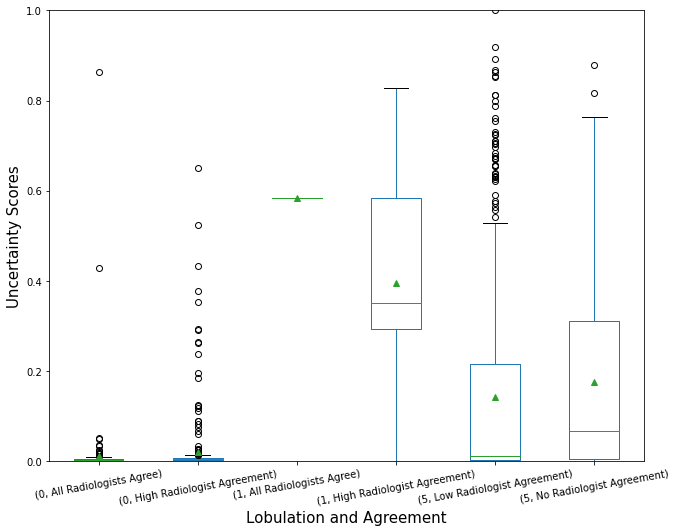

In [ ]:
plt.rcParams["figure.figsize"] = [9.50, 7.50]
plt.rcParams["figure.autolayout"] = True
#df.plot(figsize=(20,20))
newlegend1 = ['Not Lobulated', 'Lobulated', 'Unknown']
axes = df.boxplot(by=['Lobulation','Agreement'], column =['Score'], showmeans=True, showfliers=True, grid= False)
axes.set_title('')
plt.title('')
plt.suptitle('')
plt.ylim([0.0, 1.0])
plt.ylabel("Uncertainty Scores",fontdict={'fontsize':15})
plt.xlabel("Lobulation and Agreement",fontdict={'fontsize':15})
#plt.xticks([1, 2, 3, 4,5,6], ["Not Lobulated\nAll Radiologists Agree", "Not Lobulated\nHigh Radiologist Agreement", "Lobulated\nAll Radiologists Agree", "Lobulated\nHigh Radiologist Agreement", "Unknown\nLow Radiologist Agreement", "Unknown\nNo Radiologist Agreement"], rotation=10, fontsize=10)
plt.xticks(rotation=10, fontsize=10)
#plt.xticks([1, 2, 3], ['Not Spiculated', 'Spiculated', 'Unknown'])

In [ ]:
m1 = df.groupby(['Lobulation','Agreement'])['Score'].describe()
print(m1)

                                       count      mean       std       min  \
Lobulation Agreement                                                         
0          All Radiologists Agree      180.0  0.011870  0.071598  0.000195   
           High Radiologist Agreement  308.0  0.020518  0.071390  0.000314   
1          All Radiologists Agree        1.0  0.584685       NaN  0.584685   
           High Radiologist Agreement  143.0  0.395691  0.214954  0.000489   
5          Low Radiologist Agreement   564.0  0.141195  0.216896  0.000000   
           No Radiologist Agreement    140.0  0.175936  0.220171  0.000300   

                                            25%       50%       75%       max  
Lobulation Agreement                                                           
0          All Radiologists Agree      0.001489  0.002657  0.005158  0.864200  
           High Radiologist Agreement  0.001868  0.003641  0.006507  0.650200  
1          All Radiologists Agree      0.584685  0.5846

In [ ]:
m1 = df.groupby(['Lobulation','Agreement'])['Score'].median().values
print(m1)

[0.00265729 0.00364059 0.58468538 0.35073298 0.01048446 0.06610905]


In [ ]:
plt.rcParams["figure.figsize"] = [9.50, 7.50]
plt.rcParams["figure.autolayout"] = True
#df.plot(figsize=(20,20))
axes = df.boxplot(by=['Spiculation','Category'], column =['Score'], showmeans=True, showfliers=True, grid= False)
axes.set_title('')
plt.title('')
plt.suptitle('')
plt.ylim([0.0, 1.0])
plt.ylabel("Uncertainty Scores",fontdict={'fontsize':15})
plt.xlabel("Spiculation",fontdict={'fontsize':15})
plt.xticks([2, 1, 4, 3,5], ["Not Spiculated\nTraining", "Not Spiculated\nTesting", "Spiculated\nTraining", "Spiculated\nTesting", "Unknown\nLow/No"], rotation=10, fontsize=10)
#plt.xticks([1, 2, 3], ['Not Spiculated', 'Spiculated', 'Unknown'])

KeyError: ignored

In [ ]:
df.groupby(['Spiculation','Category'])['Score'].describe()

In [ ]:
df.groupby(['Spiculation','Category'])['Score'].median().values

In [ ]:
plt.rcParams["figure.figsize"] = [9.50, 7.50]
plt.rcParams["figure.autolayout"] = True
#df.plot(figsize=(20,20))
axes = df.boxplot(by=['Agreement','Category'], column =['Score'], showmeans=True, showfliers=True, grid= False)
axes.set_title('')
plt.title('')
plt.suptitle('')
plt.ylim([0.0, 1.0])
plt.ylabel("Uncertainty Scores",fontdict={'fontsize':15})
plt.xlabel("Agreement",fontdict={'fontsize':15})
plt.xticks(rotation = 10)
plt.xticks([2,1,4,3,5,6], ["All Radiologists Agree\nTraining", "All Radiologists Agree\nTesting", "High Radiologist Agreement\nTraining", "High Radiologist Agreement\nTesting", "Low Radiologist Agreement\nLow/No", "No Radiologist Agreement\nLow/No"], rotation=10, fontsize=10)
#plt.xticks([1, 2, 3], ['Not Spiculated', 'Spiculated', 'Unknown'])

In [ ]:
df.groupby(['Agreement','Category'])['Score'].describe()

In [ ]:
df.groupby(['Agreement','Category'])['Score'].median().values

## KNN Eval ##



In [ ]:
## The idea here is to pull the already evaluated uncertainty metric values out for the training data -- as we want to directly compare the uncertainty scores found in the tsne results to the knn (instead of rerunning the clustering)
# Then, we can only run knn on data with labels

## first, pull only training data from evaluated data
high_agr_ind = np.where(np.array(agreement_levels)==2)[0].tolist()
all_agr_ind = np.where(np.array(agreement_levels)==3)[0].tolist()
train_ind = high_agr_ind + all_agr_ind
knn_ids = []
for j in train_ind:
  knn_id = agreement_id2[j]
  knn_ids.append(knn_id)
# print(knn_ids) <- should be right, i checked it -- and correct length

# retrieve uncertainty values and embeddings for only training data
total_ids_list = total_ids.tolist()
knn_uncertainty_vals = []
training_embeddings = []
training_embedded = []
for k in knn_ids:
  knn_index = total_ids_list.index(k)
  knn_unc = ci_norm[knn_index]
  knn_uncertainty_vals.append(knn_unc)
  train_embedding = total_embeddings2[knn_index]
  train_embedded = tot_embedded2[knn_index]
  training_embeddings.append(train_embedding)
  training_embedded.append(train_embedded)

# retrieve "ground" truth labels
training_binary = []
for k in range(len(knn_ids)):
  val = knn_ids[k]
  #emb_ind = tot_train_inds[k]
  if val in validation_ids:
    indexk = validation_ids.index(val)
    binary = validation_label[indexk]
    training_binary.append(binary)
  if val in train_ids:
    indexk = train_ids.index(val)
    binary = train_label[indexk]
    training_binary.append(binary)

# output a dictionary to check if the binary spiculation labels are correct...
knn_dict = {'KNN ID': knn_ids, 'Label': training_binary}
knn_df = pd.DataFrame(knn_dict)
filename3 = 'test case {}/knn eval/training label check.xlsx'.format(run)
#knn_df.to_excel(filename3)

In [ ]:
## Show where KNN misclassifies points in the training & validation data, then see if we catch those points in our uncertainty metric
embeddings = training_embeddings
X_embedded = training_embedded
y_test = training_binary

## Run KNN for a large number of k values, and create an error plot from this
knn_accuracies = []
for k in range(99): #2-100
  neigh = KNeighborsClassifier(n_neighbors=k+2, metric='euclidean')
  neigh.fit(embeddings, y_test)
  y_pred_knn = neigh.predict(embeddings)
  acc_knn = knn_acc(y_test, y_pred_knn)
  knn_accuracies.append(acc_knn)
  print(k)
print(knn_accuracies)

## Create and print a plot for KNN values vs. accuracy
knn_plot = plt.figure()
k_vals = list(range(2, 101)) #2-100
plt.plot(k_vals, knn_accuracies, color='blue', linewidth=2, label='Training loss')
plt.title('KNN Accuracy Plot')
plt.xlabel('Value of K')
plt.ylabel('Accuracy')
plt.show()
name12 = 'test case {}/knn eval/knn accuracy plot'.format(run)
#knn_plot.savefig(name12)


In [ ]:
# Choose best knn classifier, and rerun it for analysis
embeddings = training_embeddings
X_embedded = training_embedded
y_test = training_binary

neigh2 = KNeighborsClassifier(n_neighbors=2, metric='euclidean')   #--> it includes itself too
neigh2.fit(embeddings, y_test)
y_pred_class2 = neigh2.predict(embeddings)
predictions = neigh2.predict_proba(embeddings)
acc_knn2 = knn_acc(y_test, y_pred_class2)
print('KNN accuracy: {}\n'.format(acc_knn2))

# Set location to print text output
filename3 = 'test case {}/knn eval/knn results'.format(run)
#kfile = open(filename3, "w")

# Extract the knn uncertainty values for all 17,500 data points
knn_uncertainty = []
for i in range(len(y_pred_class2)):
  uncertainty_num = 1 - predictions[i][y_pred_class2[i]]
  knn_uncertainty.append(uncertainty_num)
#print('Uncertainty:', knn_uncertainty)

# Place all KNN error data into variables - including the uncertainty values
errors = []
comp_unc = []
incorrect_ims = []
corr = 0
for im in range(len(y_test)):
  if y_test[im] != y_pred_class2[im]:
    uncertainty_num = 1 - predictions[im][y_pred_class2[im]] #1 - to flip it to uncertainty, not confidence (2/3 neighbors = 0.66, therefore an uncertainty of 0.33 (greater # of neighbors in same class = higher confidence = lower uncertainty))
    incorrect_ims.append(im)
    errors.append([im, y_test[im], y_pred_class2[im], predictions[im], uncertainty_num]) # image number, ground truth class, predicted (incorrect) class, array of all predictions for that image, uncertainty number for knn predictor)
    comp_unc.append([uncertainty_num, knn_uncertainty_vals[im]]) #higher value = higher uncertainties. we expect to see lower knn # and higher ci_norm #
    if knn_uncertainty_vals[im] > uncertainty_num:
      corr += 1
performance = corr/len(errors) # how many images that our metric had a higher uncertainty for, for the misclassified knn classifier (we want a higher uncertainty for misclassified points)
# this ends up not being a very strong indicator, because for k=2, it is basically only finding which points are greater than 0.5.
#str1 = 'Performance of our uncertainty metric over KNN (biased due to skew and limited KNN proba values): {}\n'.format(performance)
str2 = 'Total number of KNN misclassified points: {}\n'.format(len(incorrect_ims))
#print(str1)
print(str2)
#kfile.write(str1)
#kfile.write(str2)

## Find exactly which points KNN classifies as non-spiculated when they are actually spiculated
 # 0 = Spiculated, 1 = Not Spiculated
 # what we are looking for: ground truth class (index 1) is 0 (spiculated), but it as classified (index 2) as non spiculated (1)
spiculated_errors = []
for h in range(len(errors)):
  if errors[h][1] == 0:
    spiculated_errors.append(errors[h])
str4 = 'There were {} cases in which spiculated was classified as non-spiculated.\n'.format(len(spiculated_errors))
print(str4)
#kfile.write(str4)

# For top __% of our uncertainty scores, how many of these points are found as KNN errors?
percent_overlap = []
corr_percent_um = []
listnum = list(range(8, 822))
for r in listnum:
  indlargest = np.argpartition(knn_uncertainty_vals, -r)[-r:]
  in_common = np.intersect1d(indlargest, incorrect_ims)
  metric_acc_knn = (len(in_common)/len(incorrect_ims))*100    # number of points in common / total number of knn misclassified points
  recall_acc = (len(in_common)/len(indlargest))*100    # number of points in common / number of uncertainty points we are looking at
  percent_um = round((r/(len(y_test))*100), 0)
  corr_percent_um.append(percent_um)
  percent_overlap.append(metric_acc_knn)
  if r in [41, 82, 123, 206, 271, 411]: # top 5%, 10%, 15%, 25%, 33%, & 50%
    str3 = 'Percentage of all misclassified KNN points which are found in top {}% of uncertainty points: {}%\n'.format(str(round((r/(len(y_test))*100), 0)), str(round(metric_acc_knn, 3)))
    print(str3)
    #kfile.write(str3)
  # if r in list(range(8, 82, 8)):         # not great results -- highest was 1% with 25% coverage
    # str4 = 'Percentage of top {}% of uncertainty points which correlate to KNN misclassified images : {}%\n'.format(str(round((r/(len(y_test))*100), 0)), str(round(recall_acc, 3)))
    # print(str4)
    # kfile.write(str4)

#kfile.close()

# Print plot
knn_um_plot = plt.figure(figsize=(10, 8))
plt.plot(corr_percent_um, percent_overlap, color='blue', linewidth=2, label='Training loss')
plt.title('Percent Overlap Between KNN Misclassifications and Highest Uncertainty Data')
plt.xlabel('Percent of Highest Uncertainty Values')
plt.ylabel('Percent Overlap')
plt.show()
name14 = 'test case {}/knn eval/percent overlap'.format(run)
#knn_um_plot.savefig(name14)

# Print KNN histogram
knn_vals = save_hist(knn_uncertainty, 'KNN Uncertainty ', run, numclusters)